## ...in Python

## USA Spending API in Python

by Michael T. Moen

The USA Spending Website: [https://www.usaspending.gov/](https://www.usaspending.gov/)

The USA Spending API: [https://api.usaspending.gov/](https://api.usaspending.gov/)

These recipe examples were tested on November 3, 2023.


## 1. Get agency names and toptier codes

First, import libraries needed to pull data from the API:

In [41]:
import requests
from pprint import pprint

To obtain data from the API, it is useful to first build a dictionary containing agency names and toptier codes, the latter of which will be used to access subagency data.

In [42]:
# defines endpoint for the tptier agency codes
toptier_agencies_endpoint = "/api/v2/references/toptier_agencies/"

# define URL for obtaining agency names and codes
toptier_agencies_url = f"https://api.usaspending.gov{toptier_agencies_endpoint}"

# imports data from URL as a JSON file
toptier_data = requests.get(toptier_agencies_url).json()["results"]

# shows the total number of agencies in the data
len(toptier_data)

108

In [43]:
# shows the data for the first agency
pprint(toptier_data[0])

{'abbreviation': 'USAB',
 'active_fq': '4',
 'active_fy': '2023',
 'agency_id': 1146,
 'agency_name': 'Access Board',
 'agency_slug': 'access-board',
 'budget_authority_amount': 11458971.28,
 'congressional_justification_url': 'https://www.access-board.gov/cj',
 'current_total_budget_authority_amount': 13615337201704.1,
 'obligated_amount': 6790794.43,
 'outlay_amount': 8452843.81,
 'percentage_of_total_budget_authority': 8.416222903804242e-07,
 'toptier_code': '310'}


Now we can create a dictionary containing the agency names as keys and the toptier codes as the data. 

In [44]:
# compile dictionary containing agency names and toptier codes
toptier_codes = {record["agency_name"] : record["toptier_code"] for record in toptier_data}

toptier_codes

{'Access Board': '310',
 'Administrative Conference of the U.S.': '302',
 'Advisory Council on Historic Preservation': '306',
 'African Development Foundation': '166',
 'Agency for International Development': '072',
 'American Battle Monuments Commission': '074',
 'Appalachian Regional Commission': '309',
 'Armed Forces Retirement Home': '084',
 'Barry Goldwater Scholarship and Excellence In Education Foundation': '313',
 "Commission for the Preservation of America's Heritage Abroad": '321',
 'Commission of Fine Arts': '323',
 'Commission on Civil Rights': '326',
 'Committee for Purchase from People Who Are Blind or Severely Disabled': '338',
 'Commodity Futures Trading Commission': '339',
 'Consumer Financial Protection Bureau': '581',
 'Consumer Product Safety Commission': '061',
 'Corporation for National and Community Service': '485',
 'Corps of Engineers - Civil Works': '096',
 'Council of the Inspectors General on Integrity and Efficiency': '542',
 'Court Services and Offender Su

Finally, let's print the toptier code for a particular agency using the toptier_codes dictionary we built. This will be useful when building URLs to view other data from the API.

In [45]:
toptier_codes["Department of Transportation"]

'069'

With this information, we can access subagency data using the toptier codes.

## 2. Retrieving Data from Subagencies

The toptier_codes dictionary we created above contains every agency name in the API. For this example, we'll look at the total obligations of each subagency of the Department of Defense.

In [46]:
# set this to the desired department
agency_name = 'Department of Defense'

subagency_url = f"https://api.usaspending.gov/api/v2/agency/{toptier_codes[agency_name]}/sub_agency/?fiscal_year=2023"

subagency_data = requests.get(subagency_url).json()["results"]

# define dictionary 'subagencies' with subagency names as keys and total_obligations as the data
subagencies = {data['name']: data['total_obligations'] for data in subagency_data}

subagencies

{'Department of the Navy': 122441059764.64,
 'Department of the Army': 86153521675.79,
 'Department of the Air Force': 76578390702.03,
 'Defense Logistics Agency': 37954221623.43,
 'Defense Health Agency': 17890042504.38,
 'Missile Defense Agency': 6490727943.64,
 'Defense Information Systems Agency': 4916713078.14,
 'USTRANSCOM': 4166637820.74,
 'U.S. Special Operations Command': 3462416840.05,
 'Washington Headquarters Services': 2669412724.56}

Now, let's import the matplotlib and numpy libraries to create some data visualizations.

In [47]:
import matplotlib.pyplot as plt
import numpy as np

We'll represent our data using a pie chart.

Note: to change the color scheme of this list, you can select a different color map (cmap) from [https://matplotlib.org/stable/gallery/color/colormap_reference.html](https://matplotlib.org/stable/gallery/color/colormap_reference.html)

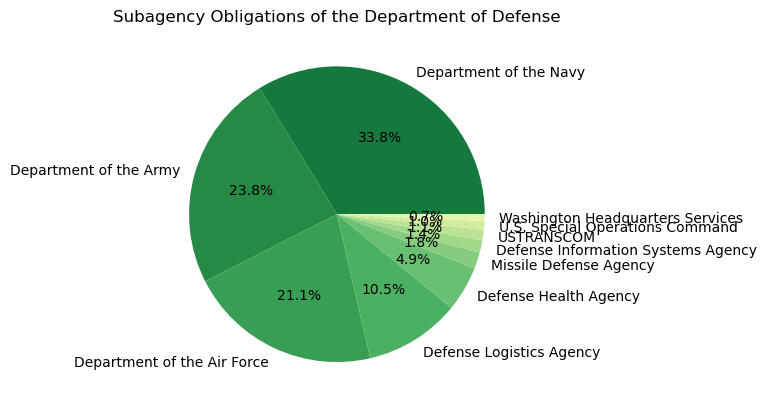

In [48]:
subagency_names = list(subagencies.keys())
subagency_obligations = list(subagencies.values())

# configure colors of pie chart
cmap = plt.get_cmap('YlGn_r')
colors = cmap(np.linspace(0.2, 0.8, len(subagency_obligations)))

fig, ax = plt.subplots()
plt.pie(subagency_obligations, labels=subagency_names, autopct='%1.1f%%', colors=colors)
plt.title("Subagency Obligations of the " + agency_name)
plt.show()

To make this pie chart easier to read, let's create an "Other" category to add the Defense Advanced Research Projects Agency and Washington Headquarters Services to.

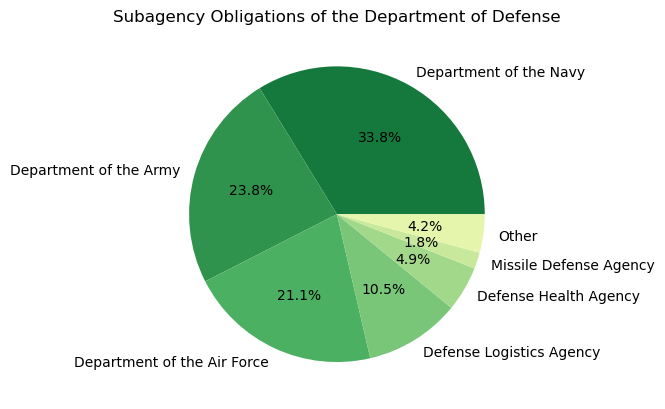

In [49]:
smallest_percent_allowed = 0.015 # any sector under this threshold will be combined into an "Other" category in the pie chart
small_slices = 0 # the number of slices below the threshold above
agency_total_obligations = sum(subagencies.values()) # the total obligations of the agency

# count the number of small slices
for i in subagency_obligations:
    if i < smallest_percent_allowed * agency_total_obligations:
        small_slices += 1

# if there is more than one slice smaller than the threshold specified above, this combines those slices into an "Other" slice
if small_slices > 1:
    other_obligations = 0
    i = len(subagency_obligations)-1
    while i >= 0:
        if subagency_obligations[i] < smallest_percent_allowed * agency_total_obligations:
            other_obligations += subagency_obligations[i]
            subagency_names.pop(i)
            subagency_obligations.pop(i)
        i -= 1
    subagency_obligations.append(other_obligations)
    subagency_names.append("Other")

# configure color of pie chart
colors = cmap(np.linspace(0.2, 0.8, len(subagency_obligations)))

fig, ax = plt.subplots()
plt.pie(subagency_obligations, labels=subagency_names, autopct='%1.1f%%', colors=colors)
plt.title("Subagency Obligations of the " + agency_name)

plt.show()

## 3. Accessing Fiscal Data Per Year

We can use the API to examine the annual budget of an agency from 2017 onward.

In [50]:
agency_name = "Department of Health and Human Services"

budgetary_resources_url = f"https://api.usaspending.gov/api/v2/agency/{toptier_codes[agency_name]}/budgetary_resources/"

budgetary_resources_data = requests.get(budgetary_resources_url).json()["agency_data_by_year"]

# number of year contained in the data
len(budgetary_resources_data)

8

Now we can create a dictionary to store the budgets using the years as keys.

In [51]:
# create budget_by_year dictionary with fiscal_year as the key and agency_total_obligated as the data
budget_by_year = {list_item['fiscal_year'] : list_item['agency_total_obligated'] for list_item in budgetary_resources_data}

# print results
budget_by_year

{2024: None,
 2023: 2241097923975.28,
 2022: 2452969781323.39,
 2021: 2355524286884.46,
 2020: 2198882208891.79,
 2019: 1814270463757.37,
 2018: 1679128003253.74,
 2017: 1646989531123.68}

The budget data for the current year (2023 at the time of writing) does not contain the entire annual budget, so let's remove that entry from the data along with the 2024 entry.

In [52]:
budget_by_year.pop(2023)
budget_by_year.pop(2024)

budget_by_year

{2022: 2452969781323.39,
 2021: 2355524286884.46,
 2020: 2198882208891.79,
 2019: 1814270463757.37,
 2018: 1679128003253.74,
 2017: 1646989531123.68}

Now we'll use matplotlib to create a bar graph for this information.

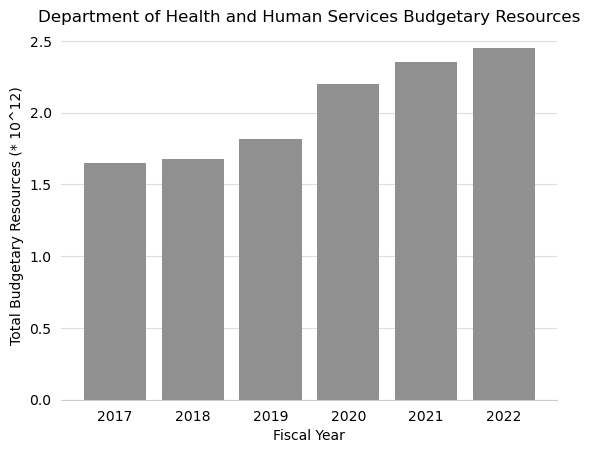

In [53]:
lists = sorted(budget_by_year.items())
years, budgets = zip(*lists)

# create scale for bar graph
min = sorted(list(budgets), key=float)[0]
exponent = len(str(int(min)))-1

budgets = [x/(10**exponent) for x in budgets]

fig, ax = plt.subplots()

# format the bar graph
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#CCCCCC')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#DDDDDD')
ax.xaxis.grid(False)

plt.bar(years, budgets, color='#909090')
plt.title(agency_name + " Budgetary Resources")
plt.xlabel("Fiscal Year")
plt.ylabel(f"Total Budgetary Resources (* 10^{exponent})")
plt.show()

## 4. Breaking Down Budget Categories

We can use the API to view the breakdown the spending of a particular agency.

In [54]:
agency_name = "Department of the Interior"

obligations_by_category_url = f"https://api.usaspending.gov/api/v2/agency/{toptier_codes[agency_name]}/obligations_by_award_category/?fiscal_year=2023"

obligations_by_category_data = requests.get(obligations_by_category_url).json()

# Stores the total aggregated obligations for this particular agency
total_aggregated_amount = obligations_by_category_data["total_aggregated_amount"]

obligations_by_category_data = obligations_by_category_data["results"]

# print results
obligations_by_category_data

[{'category': 'contracts', 'aggregated_amount': 7796096732.07},
 {'category': 'direct_payments', 'aggregated_amount': 3311523401.72},
 {'category': 'grants', 'aggregated_amount': 7198549492.06},
 {'category': 'idvs', 'aggregated_amount': 3580835.81},
 {'category': 'loans', 'aggregated_amount': 0.0},
 {'category': 'other', 'aggregated_amount': 335594193.07}]

Let's create a dictionary to store this data.

In [55]:
budget_breakdown = {}

# add entry to budget_breakdown dictionary only if the amount is greater than zero
for record in obligations_by_category_data:
    if record["aggregated_amount"] > 0:
        budget_breakdown[record["category"]] = record["aggregated_amount"]

budget_breakdown

{'contracts': 7796096732.07,
 'direct_payments': 3311523401.72,
 'grants': 7198549492.06,
 'idvs': 3580835.81,
 'other': 335594193.07}

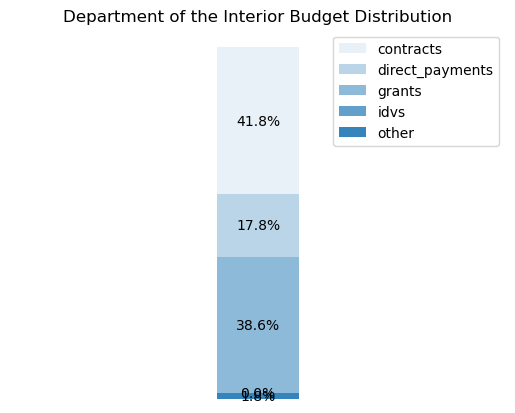

In [56]:
budget_type = list(budget_breakdown.keys())
budget_amount = list(budget_breakdown.values())
budget_percentages = [x/total_aggregated_amount for x in budget_amount]

fig, ax = plt.subplots()
bottom = 1

for j, (height, label) in enumerate([*zip(budget_percentages, budget_type)]):
    bottom -= height
    bc = ax.bar(0, height=height, label=label, width=2, bottom=bottom, alpha=0.1 + 0.2 * j, align='center', color='C0')
    ax.bar_label(bc, labels=[f"{height:.1%}"], label_type='center')

ax.set_title(agency_name +' Budget Distribution')
ax.legend()
ax.axis('off')
ax.set_xlim(-6, 6)

plt.show()

Now we can plot this data on a pie chart.

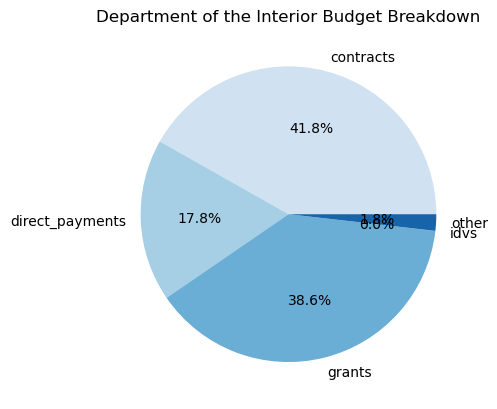

In [57]:
lists = sorted(budget_breakdown.items())
types, budgets = zip(*lists)

fig, ax = plt.subplots()

# configure color of pie chart
cmap = plt.get_cmap('Blues')
colors = cmap(np.linspace(0.2, 0.8, len(budgets)))

plt.pie(budgets, labels=types, autopct='%1.1f%%', colors=colors)
plt.title(agency_name + " Budget Breakdown")
plt.show()